<a href="https://colab.research.google.com/github/google/deepvariant/blob/r1.9/docs/visualizing_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example was done using [Colab](https://colab.research.google.com/
). You can read and use the Python code in other environments if you have never used Colab before. For example, we used a path to a file in gs://, but you can also just copy that file to your environment and use a local path instead.

This example is for **advanced** users who want to understand the data representation. **You do NOT need to understand this in order to use DeepVariant.**

## Did you know there is a `show_examples` binary you can use?

There is a `show_examples` binary in https://github.com/google/deepvariant/blob/r1.9/docs/show-examples.md that you can use to visualize DeepVariant examples.

`show_examples` uses the same core library used in this Colab.

# Visualizing DeepVariant examples

DeepVariant represents putative variants as pileup image tensors and classifies them using a convolutional neural network.

In this notebook, we will inspect some DeepVariant examples and visualize the pileup images.

We (the DeepVariant team) also wrote a blog post that explains what these pileup images are and how they are used in DeepVariant:
https://google.github.io/deepvariant/posts/2020-02-20-looking-through-deepvariants-eyes/

In [ ]:
! pip install git+https://github.com/google/deepvariant.git@r1.9

In [ ]:
#@title Install protoc to be used later.
PROTOC_VERSION = "26.1" # Example: "26.1", "25.3", etc. Check releases page for the latest
PROTOC_ZIP = f"protoc-{PROTOC_VERSION}-linux-x86_64.zip"
DOWNLOAD_URL = f"https://github.com/protocolbuffers/protobuf/releases/download/v{PROTOC_VERSION}/{PROTOC_ZIP}"

# Download the protoc zip file
!curl -LO {DOWNLOAD_URL}

# Unzip the archive
!unzip -o {PROTOC_ZIP} -d protoc_install

# Move the protoc binary to a directory in your PATH
!sudo mv protoc_install/bin/protoc /usr/local/bin/

# Move the include files to a standard location
!sudo mv protoc_install/include/* /usr/local/include/

# Optional: Clean up the downloaded zip and extracted folder
!rm {PROTOC_ZIP}
!rm -rf protoc_install

# Verify the installation
!protoc --version

In [ ]:
!git clone https://github.com/google/deepvariant.git
%cd deepvariant
! git checkout r1.9
! sudo python3 setup.py build_proto


In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/deepvariant" #Adjust the path if necessary


In [ ]:
import deepvariant
import tensorflow as tf
from third_party.nucleus.util import vis
print(tf.__version__)

Download a file of DeepVariant examples from Google Cloud Storage to the local file storage of this notebook. DeepVariant examples are stored in TFRecord format.

In [ ]:
!gsutil -q cp gs://deepvariant/datalab-testdata/make_examples_datalab.tfrecord.gz /tmp/make_examples_colab.tfrecord.gz

In [ ]:
examples_path = '/tmp/make_examples_colab.tfrecord.gz'

# Show one DeepVariant example
We will use the nucleus.util.vis module to inspect and visualize a single DeepVariant example.

Locus ID with alt: chr20:19503712_T_C
Draw the channels:


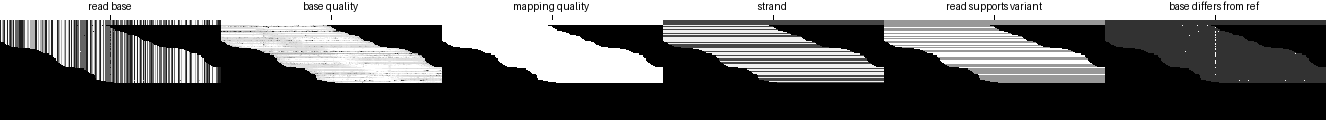

Truth label: 1


In [ ]:
dataset = tf.data.TFRecordDataset(examples_path, compression_type="GZIP")

# Take a single example and show the deepvariant pileup image for it.
for e in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(e.numpy())

  # For example, in chr20:19503712_T_C, T is the reference allele and C is the
  # alternate allele that is proposed in this pileup image.
  print("Locus ID with alt:", vis.locus_id_with_alt(example))
  print("Draw the channels:")
  vis.draw_deepvariant_pileup(example)

  print("Truth label:", vis.label_from_example(example))

# You can also save the images as .png files

In [ ]:
for e in dataset.take(10):
  example = tf.train.Example()
  example.ParseFromString(e.numpy())

  # For example, in chr20:19503712_T_C, T is the reference allele and C is the
  # alternate allele that is proposed in this pileup image.
  filename = 'pileup_{}_truth={}.png'.format(vis.locus_id_with_alt(example), vis.label_from_example(example))
  vis.draw_deepvariant_pileup(example, path=filename, show=False)

This creates 10 PNG images labeled with locus IDs and truth labels.

In [ ]:
! ls *png

'pileup_chr20:12534952_A_G_truth=1.png'
'pileup_chr20:19503712_T_C_truth=1.png'
'pileup_chr20:24448381_T_A_truth=2.png'
'pileup_chr20:32765978_A_G_truth=1.png'
'pileup_chr20:37886261_G_A_truth=1.png'
'pileup_chr20:55019799_C_T_truth=1.png'
'pileup_chr20:59581048_T_G_truth=0.png'
'pileup_chr20:64063271_A_G_truth=0.png'
'pileup_chr20:7912729_G_A_truth=1.png'
'pileup_chr20:845848_G_C_truth=2.png'


## Flexible, modular functions
The nucleus.util.vis library also has smaller building blocks you can use if you need more flexibility.

Extracting the variant:
reference_bases: "T"
alternate_bases: "C"
calls {
  info {
    key: "VAF"
    value {
      values {
        number_value: 0.43636363636363634
      }
    }
  }
  info {
    key: "DP"
    value {
      values {
        number_value: 55
      }
    }
  }
  info {
    key: "AD"
    value {
      values {
        number_value: 31
      }
      values {
        number_value: 24
      }
    }
  }
  genotype: -1
  genotype: -1
  call_set_name: "training"
}
end: 19503713
reference_name: "chr20"
start: 19503712


Shape of the pileup numpy array: (100, 221, 6)

Number of channels: 6

Showing just the first channel:


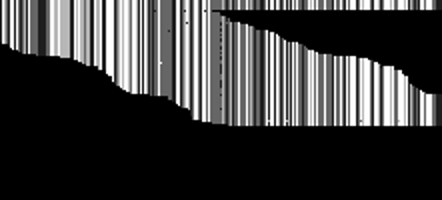

In [ ]:
for e in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(e.numpy())
  print("Extracting the variant:")
  print(vis.variant_from_example(example))

  # Get the pileup image as an array.
  arr = vis.get_image_array_from_example(example)
  print("\nShape of the pileup numpy array:", arr.shape)
  # Split that array into channels.
  channels = vis.split_3d_array_into_channels(arr)
  print("\nNumber of channels:", len(channels))

  # Visualize the numpy array as an image.
  print("\nShowing just the first channel:")
  vis.array_to_png(channels[0])